In [9]:
%load_ext autoreload
%autoreload 2
import stim
import numpy as np
import matplotlib.pyplot as plt
import sinter
from typing import List
import surface_general_defect
from surface_general_defect import LogicalQubit

In [10]:
def gen_faulty_qubit_coords(d):
    return [(d-1, i) for i in range(2, 2*d-3, 4)]

In [84]:
def gen_circuit_with_deforms(d, r, missing_coords):
    # error probs aren't the point
    logical_qubit = surface_general_defect.LogicalQubit(d, 0.001, 0.0005, 0.003, missing_coords=missing_coords, get_metrics=True)
    if len(logical_qubit.defect) == 0:
        circuit = logical_qubit.generate_stim(r)
    else:
        circuit = logical_qubit.generate_stim_shell(r)
    return logical_qubit, circuit

In [12]:
def gen_stim_file(d, r, missing_coords, folder=None, fname=None):
    if missing_coords is None:
        missing_coords = []
    if folder is None:
        folder = "."
    if fname is None:
        fname = f"surface_d{d}r{r}_cut{len(missing_coords)}.stim"
    file = f"{folder}/{fname}"
    print(fname)
    if type(missing_coords) is int:
        missing_coords = gen_faulty_qubit_coords(d)[:missing_coords]
    
    logical_qubit, circuit = gen_circuit_with_deforms(d, r, missing_coords)

    import os
    os.makedirs(folder, exist_ok=True)
    circuit.to_file(file)

In [20]:
faulty_qubits = gen_faulty_qubit_coords(7)
faulty_qubits

[(6, 2), (6, 6), (6, 10)]

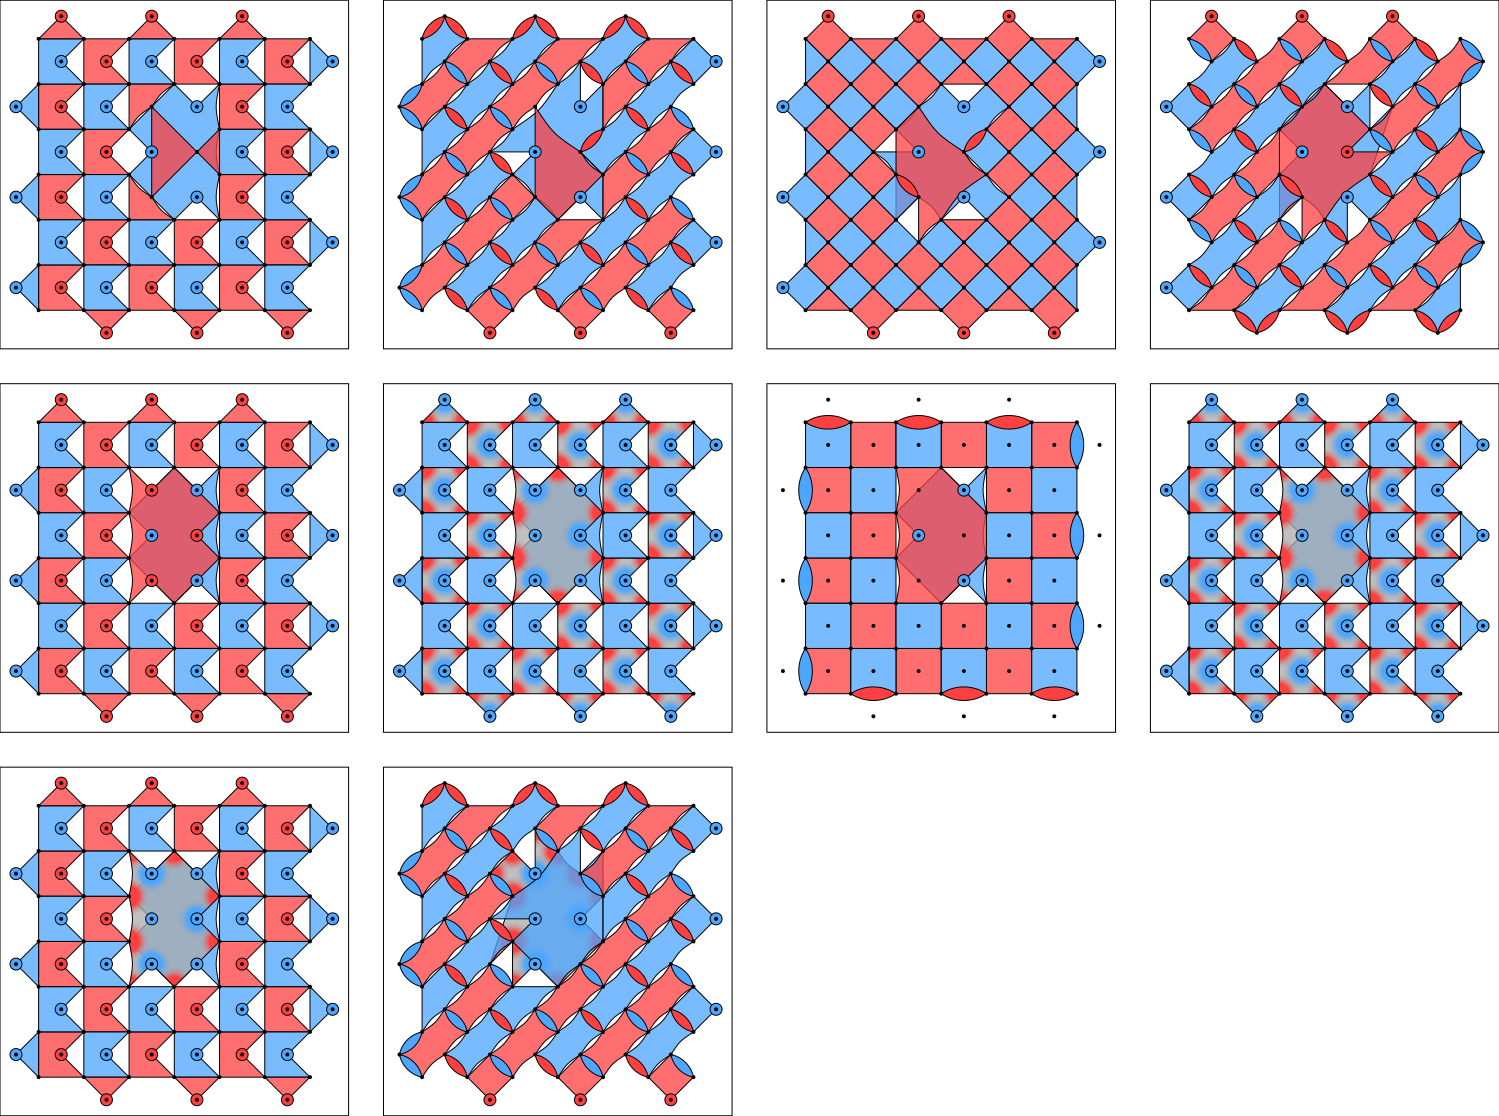

In [108]:
logical_qubit, c = gen_circuit_with_deforms(7, 15, [(6, 6), (6, 4)])
c.diagram("detslice-svg", tick=range(10, 20))

In [30]:
gen_stim_file(7, 15, [], "stim_files")

In [85]:
# === parameters ===
import os
from pathlib import Path

d = 9                              # code distance
r = 3 * d                          # rounds of stabilizer measurement (adjust as desired)
EDGE_BUFFER = 1                    # min distance from boundary to avoid deformation; set 2 if needed
SWEEP_AXIS = "y"                   # move defect along +x from center (keep y=center)

out_folder = Path(f"stim_circuits_d{d}_defect_sweep")
out_folder.mkdir(parents=True, exist_ok=True)

# === helpers (updated for right-edge, even-y defects) ===
def edge_distance(x: int, y: int, d: int) -> int:
    """
    Distance in 'even steps' from the nearest data-qubit edge (origin-side).
    Assumes x and y are even (data-qubit sites).
    Example (d=9): (8,2)->1, (8,4)->2, (8,6)->3, (8,8)->4.
    """
    if (x % 2) != 0 or (y % 2) != 0:
        raise ValueError(f"edge_distance expects even coords; got ({x},{y}).")
    return min(x // 2, y // 2)


def defect_positions_right_edge_even_y(d: int, start_y: int = 2):
    """
    Produce defects at x = d-1 (which is even when d is odd) and even y's.
    For d=9: (8,2), (8,4), (8,6), (8,8).
    """
    x = d - 1
    if x % 2 != 0:
        raise ValueError(f"d-1 must be even for data-qubit column; got d={d}.")
    ys = [y for y in range(start_y, d, 2) if y % 2 == 0]
    return [(x, y) for y in ys]

# === build sweep of defect positions ===
defect_positions = defect_positions_right_edge_even_y(d, start_y=0)
print(defect_positions)

# === call your generator for each scenario ===
# We will name files with the index and the computed edge-distance.
generated = []  # list of dicts: {"path": Path, "pos": (x,y), "edge_dist": int}

def circuit_filename(idx: int, x: int, y: int, dist: int) -> str:
    return f"d{d}_r{r}_defect_x{x}_y{y}_edgeDist{dist}.stim"

# IMPORTANT: this function must exist in your environment.
# Signature provided by you: gen_stim_file(d, r, missing_coords, folder)
# from your_module import gen_stim_file
baseline_name = "baseline.stim"
folder = str(out_folder)
print(folder)
print(baseline_name)
missing_coords = []  # no missing qubits → baseline circuit
gen_stim_file(d, r, missing_coords, folder=folder, fname=baseline_name)

generated = [{
    "path": out_folder / baseline_name,
    "pos": None,
    "edge_dist": 0,
    "index": 0,
    "series": "baseline"
}]

for i, (x, y) in enumerate(defect_positions):
    dist = edge_distance(x, y, d)
    fname = circuit_filename(i, x, y, dist)
    # Single missing data qubit at (x,y)
    missing_coords = [(x, y)]
    gen_stim_file(d, r, missing_coords, folder=folder, fname=fname)
    # If your generator decides the name, skip below. Otherwise, if it returns a path, use that.
    # Assuming it writes to f"{folder}/{fname}" — if not, you can rename or store the actual path.
    generated.append({
        "path": Path(folder) / fname,
        "pos": (x, y),
        "edge_dist": dist,
        "index": i,
        "series": "defect"
    })

# If your gen_stim_file doesn’t control filenames, you can also
# adapt the above to capture its return value and store that in 'path'.
print(f"Generated {len(generated)} circuits in: {out_folder.resolve()}")
for g in generated:
    print(g["index"], g["pos"], "edge_dist=", g["edge_dist"], "->", g["path"].name)


[(8, 0), (8, 2), (8, 4), (8, 6), (8, 8)]
stim_circuits_d9_defect_sweep
baseline.stim
baseline.stim
d9_r27_defect_x8_y0_edgeDist0.stim
d9_r27_defect_x8_y2_edgeDist1.stim
d9_r27_defect_x8_y4_edgeDist2.stim
d9_r27_defect_x8_y6_edgeDist3.stim
d9_r27_defect_x8_y8_edgeDist4.stim
Generated 6 circuits in: /Users/eli/dev/superstabilizer_splicing/python_deformation_generator/stim_circuits_d9_defect_sweep
0 None edge_dist= 0 -> baseline.stim
0 (8, 0) edge_dist= 0 -> d9_r27_defect_x8_y0_edgeDist0.stim
1 (8, 2) edge_dist= 1 -> d9_r27_defect_x8_y2_edgeDist1.stim
2 (8, 4) edge_dist= 2 -> d9_r27_defect_x8_y4_edgeDist2.stim
3 (8, 6) edge_dist= 3 -> d9_r27_defect_x8_y6_edgeDist3.stim
4 (8, 8) edge_dist= 4 -> d9_r27_defect_x8_y8_edgeDist4.stim


In [87]:
# Requires: pip install sinter stim (if not already installed)
import math
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os

import stim
import sinter

# If you ran Cell 1 in the same session, 'generated' is already defined.
# Otherwise, reconstruct it by scanning the folder:
if 'generated' not in globals():
    d = 9
    r = 3 * d
    out_folder = Path(f"stim_circuits_d{d}_defect_sweep")
    def parse_meta_from_name(name: str):
        # expects: d{d}_r{r}_defect_x{X}_y{Y}_edgeDist{E}.stim
        parts = name.replace(".stim","").split("_")
        meta = {}
        for p in parts:
            if p.startswith("x"):
                meta["x"] = int(p[1:])
            elif p.startswith("y"):
                meta["y"] = int(p[1:])
            elif p.startswith("edgeDist"):
                meta["edge_dist"] = int(p[len("edgeDist"):])
        return meta
    generated = []
    for i, p in enumerate(sorted(out_folder.glob("*.stim"))):
        meta = parse_meta_from_name(p.name)
        generated.append({
            "path": p,
            "pos": (meta.get("x"), meta.get("y")),
            "edge_dist": meta.get("edge_dist"),
            "index": i,
        })
    if not generated:
        raise RuntimeError(f"No .stim circuits found in {out_folder} — run Cell 1 first.")

tasks = []
for g in generated:
    # Load circuit; if your stim files include detectors (DETECTOR ops), sinter will compute LER.
    if g["series"] == "baseline": continue
    c = stim.Circuit.from_file(str(g["path"]))
    tasks.append(
        sinter.Task(
            circuit=c,
            # metadata for plotting/analysis
            decoder="pymatching",
            json_metadata={
                "edge_dist": g["edge_dist"],
                "pos": g["pos"],
                "fname": g["path"].name,
                "series": "defect"
            },
        )
    )

# Baseline (no-defect) task
baseline_circ = stim.Circuit.from_file(str(out_folder / "baseline.stim"))
baseline_task = sinter.Task(
    circuit=baseline_circ,
    decoder="pymatching",
    json_metadata={"series": "baseline"}
)
tasks.append(baseline_task)

# Collect data
stats = list(sinter.collect(
    tasks=tasks,
    max_errors=1000,              # stop criterion by error count (optional)
    max_shots=1_000_000,               # total shots cap (optional)
    num_workers=max(1, os.cpu_count() or 1),
    print_progress=True,
))


Starting 10 workers...
6 tasks left:
  workers    decoder eta shots_left errors_left json_metadata                                                                
        1 pymatching   ?    1000000        1000 edge_dist=0,pos=(8, 0),fname=d9_r27_defect_x8_y0_edgeDist0.stim,series=defect
        1 pymatching   ?    1000000        1000 edge_dist=1,pos=(8, 2),fname=d9_r27_defect_x8_y2_edgeDist1.stim,series=defect
        2 pymatching   ?    1000000        1000 edge_dist=2,pos=(8, 4),fname=d9_r27_defect_x8_y4_edgeDist2.stim,series=defect
        2 pymatching   ?    1000000        1000 edge_dist=3,pos=(8, 6),fname=d9_r27_defect_x8_y6_edgeDist3.stim,series=defect
        2 pymatching   ?    1000000        1000 edge_dist=4,pos=(8, 8),fname=d9_r27_defect_x8_y8_edgeDist4.stim,series=defect
        2 pymatching  6m     999983        1000 series=baseline                                                              
6 tasks left:
  workers    decoder eta shots_left errors_left json_metadata      

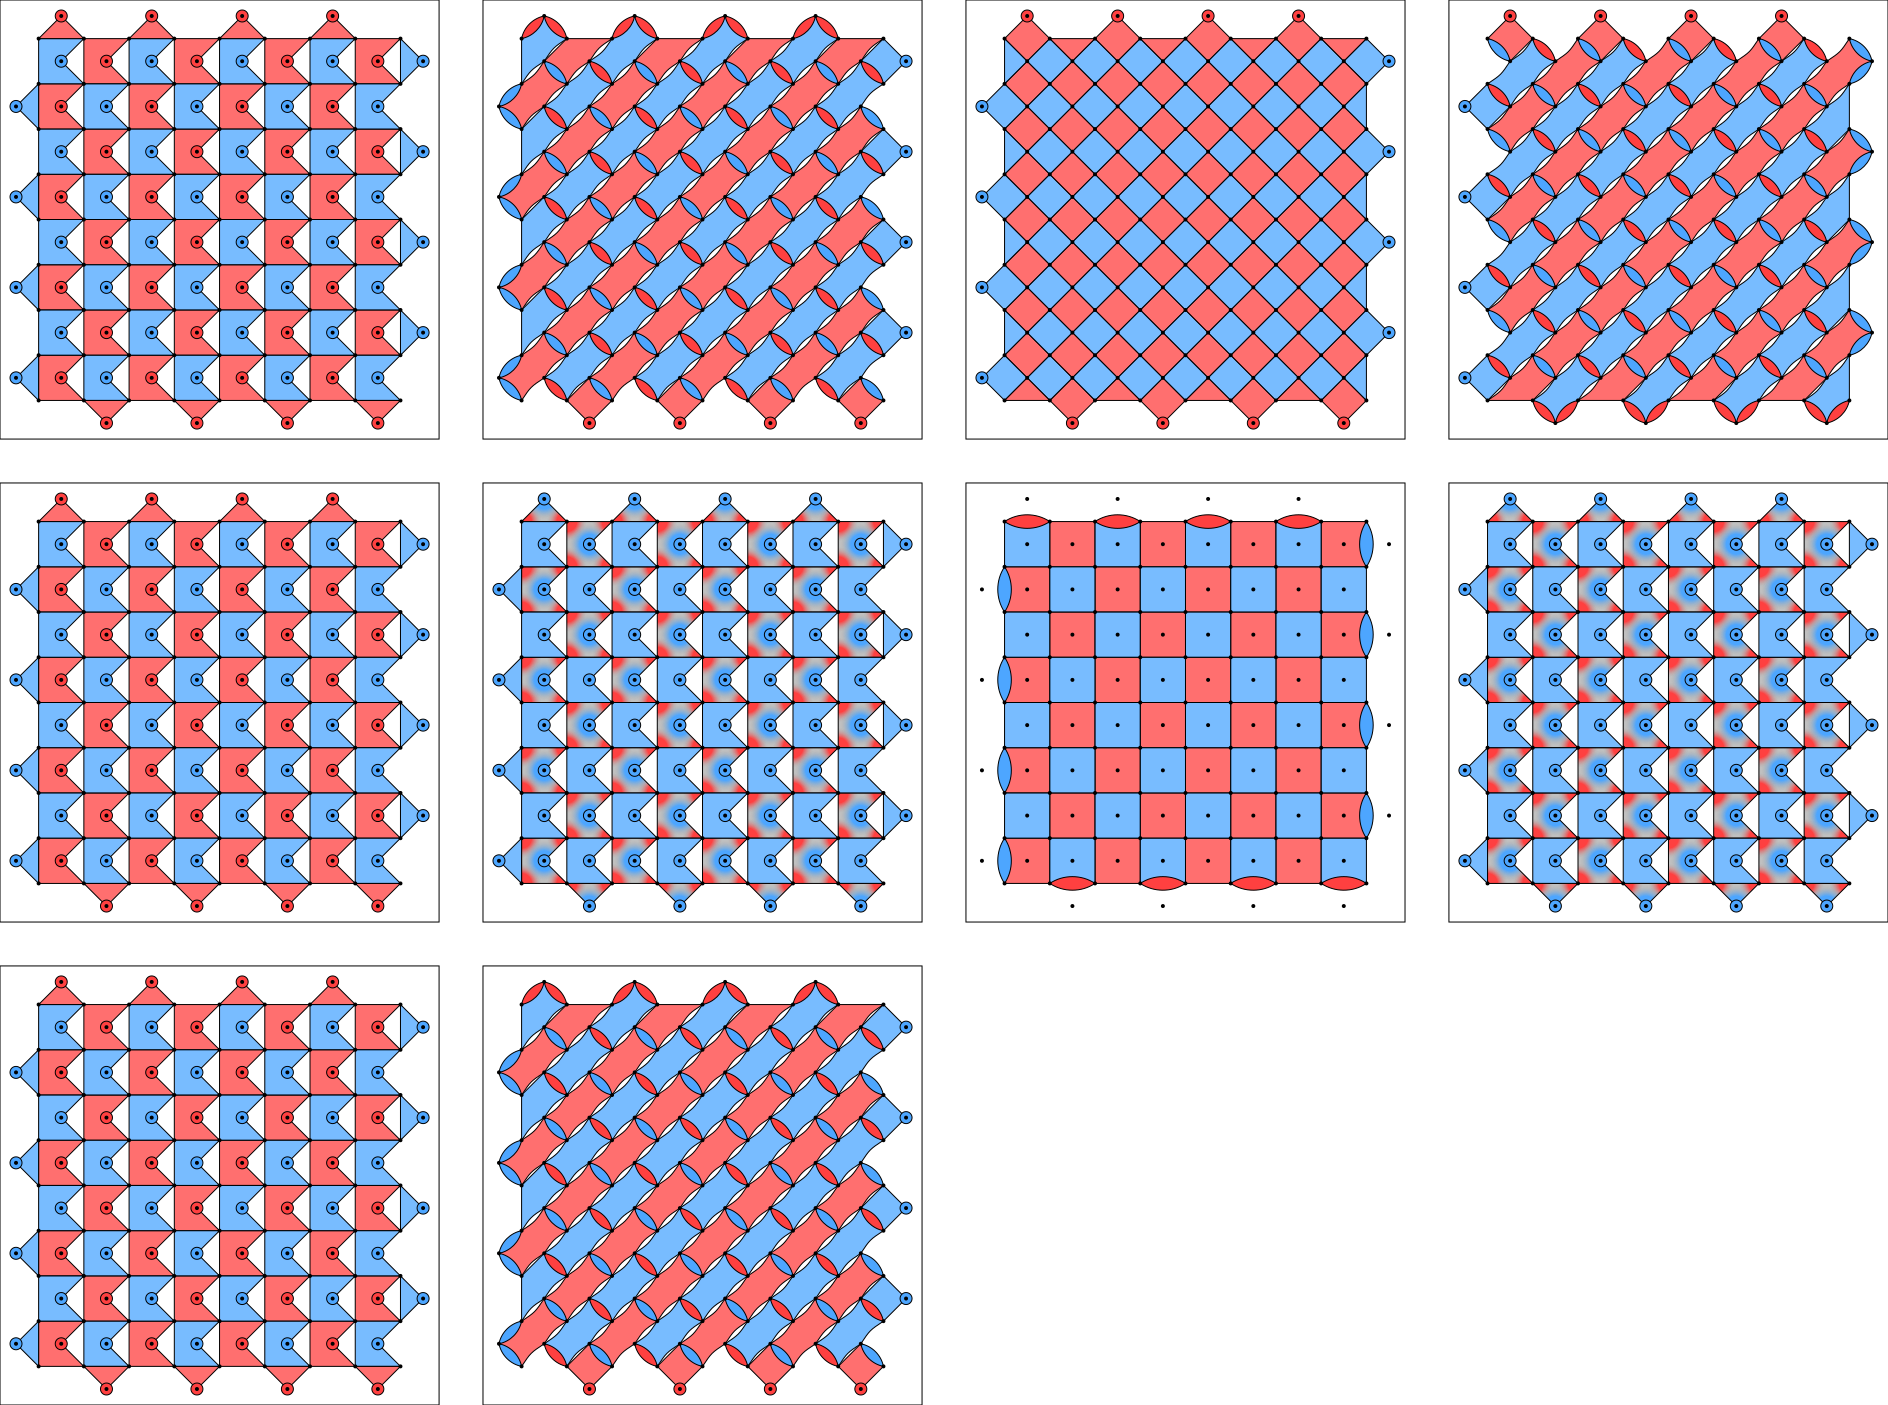

In [ ]:
tasks[5].circuit.diagram('detslice-svg', tick=range(10, 20))

In [88]:
stats

[sinter.TaskStats(strong_id='aa3ea9cdd926824fabc990302c9e686f12e405c9bb37a3fe9b11e39de4090e72', decoder='pymatching', json_metadata={'series': 'baseline'}, shots=977289, errors=np.int64(1004), seconds=32.4494165959768),
 sinter.TaskStats(strong_id='bf8e63c40b7111e0262c02f1ac70769446efe92484808419387de6ea347446e8', decoder='pymatching', json_metadata={'edge_dist': 0, 'pos': (8, 0), 'fname': 'd9_r27_defect_x8_y0_edgeDist0.stim', 'series': 'defect'}, shots=776276, errors=np.int64(1281), seconds=24.66931686317548),
 sinter.TaskStats(strong_id='9d97ec951610c40a303d8b47a1390428005871e715abbe75804af1720e0ba8f7', decoder='pymatching', json_metadata={'edge_dist': 1, 'pos': (8, 2), 'fname': 'd9_r27_defect_x8_y2_edgeDist1.stim', 'series': 'defect'}, shots=374394, errors=np.int64(1277), seconds=25.60821423958987),
 sinter.TaskStats(strong_id='cf4722442c22ecd9bfb4fc727dca44d4adb7f8f84b9427eef5d36e5b8bf17681', decoder='pymatching', json_metadata={'edge_dist': 4, 'pos': (8, 8), 'fname': 'd9_r27_defec

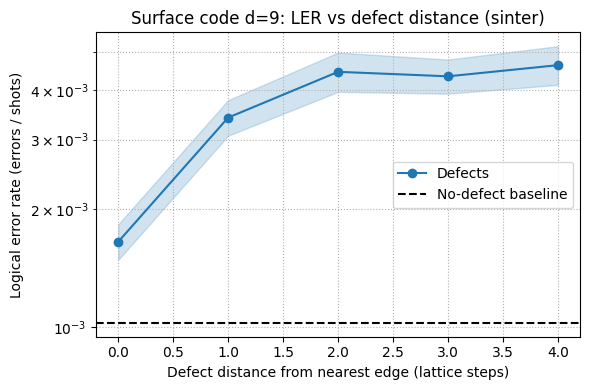

In [111]:

defect_stats = [s for s in stats if s.json_metadata["series"] == "defect"]

baseline_stats = [s for s in stats if s.json_metadata["series"] == "baseline"]
baseline_ler = None
if baseline_stats:
    b = baseline_stats[0]
    baseline_ler = int(b.errors) / max(1, int(b.shots))

# --- plot with sinter.plot_error_rate (no pandas needed)
fig, ax = plt.subplots(figsize=(6, 4))

sinter.plot_error_rate(
    ax=ax,
    stats=defect_stats,
    # x-axis: your "defect distance from edge" stored in metadata
    x_func=lambda s: s.json_metadata["edge_dist"],
    # y-axis: tell sinter how to compute "failures per shot"
    #   numerator -> failures
    failure_values_func=lambda s: int(s.errors),
    #   denominator -> shots
    # failure_units_per_shot_func=lambda s: s.shots,
    failure_units_per_shot_func=lambda s: 1,
    # single curve (leave as None) or change to group by something in metadata
    group_func=lambda s: None,
    # keep all points
    filter_func=lambda s: True,
    # styling for the curve/points
    plot_args_func=lambda i, g, gs: dict(marker="o", linestyle="-", label="Defects" if i == 0 else None, color="C0"),
    # optional line fits across the curve; comment out if you don't want fits
    # line_fits=('linear',),
    # show point labels like "errors/shots" next to each dot (optional)
    point_label_func=lambda s: None,
)

# add the horizontal baseline while *keeping* it in the stats list
if baseline_ler is not None:
    ax.axhline(y=baseline_ler, color="black", linestyle="--", linewidth=1.5, label="No-defect baseline")


ax.legend(loc="best", frameon=True)
ax.set_xlabel("Defect distance from nearest edge (lattice steps)")
ax.set_ylabel("Logical error rate (errors / shots)")
ax.set_yscale("log")
ax.set_title(f"Surface code d={d}: LER vs defect distance (sinter)")
ax.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.show()